In [1]:
'''
a, b
parsing data
'''
import os
import numpy as np
import pandas as pd
BENDING_ONE_FILE_COUNT = 7
BENDING_TWO_FILE_COUNT = 6
GENERAL_FILE_COUNT = 15
FOLDERS = ['bending1','bending2','walking','standing','sitting','lying','cycling']
COLUMN_NAMES = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13","avg_rss23", "var_rss23"]
#global data
activity_data_all = [] 

# read benging 1 data 
bending_one_data = []
for i in range (BENDING_ONE_FILE_COUNT): 
    fileNum = str(i+1)
    bending_one_data.append(pd.read_csv("AReM/bending1/dataset" + fileNum + ".csv", sep=",", header=None, skiprows=5))
    bending_one_data[i].columns = COLUMN_NAMES

# read benging 2 data 
bending_two_data = []
for i in range (BENDING_TWO_FILE_COUNT):
    fileNum = str(i+1)
    #4th dataset ill formated 
    if fileNum == "4" :
        bending_two_data.append(pd.read_csv("AReM/bending2/dataset" + fileNum + ".csv", 
                                sep=" ", header=None, skiprows=5, usecols=[0,1,2,3,4,5,6]))
    else : 
        bending_two_data.append(pd.read_csv("AReM/bending2/dataset" + fileNum + ".csv", sep=",", header=None, skiprows=5))
    bending_two_data[i].columns = COLUMN_NAMES

def parseActivityData(folder_name):
    activity_data = []
    for i in range (GENERAL_FILE_COUNT): 
        fileNum = str(i+1)
        temp_file_path = "AReM/" + folder_name + "/dataset" + fileNum + ".csv"
        activity_data.append(pd.read_csv(temp_file_path, sep=",", header=None, skiprows=5,usecols=[0, 1, 2,3,4,5,6]))
        activity_data[i].columns = COLUMN_NAMES
    return activity_data

# read other data
walking_data = parseActivityData("walking")
standing_data = parseActivityData("standing")
sitting_data = parseActivityData("sitting")
lying_data = parseActivityData("lying")
cycling_data = parseActivityData("cycling")

activity_data_all.append (bending_one_data)
activity_data_all.append (bending_two_data)
activity_data_all.append (walking_data)
activity_data_all.append (standing_data)
activity_data_all.append (sitting_data)
activity_data_all.append (lying_data)
activity_data_all.append (cycling_data)


### c(i)

Traditional time domain features such as min, max and mean are used in time series analysis. 
Depending on the problem, peopel cloud also use a vareity of other features such as lag features, rolling windows or expand windows (use previous value to predict future value).
## Sources
Basic Time Series Features: https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/
Quora: https://www.quora.com/How-can-I-extract-the-features-from-time-series

In [2]:
'''
c(ii, iii)
bootstrap tutorial: https://www.youtube.com/watch?v=8zo3C8H2AuQ
'''
#obtain 7 time domain features for 6 serires
feature_names = ["min", "max", "mean", "median", "std_dev", "1st_qrt", "3rd_qrt"]
feature_column_names = [] 
for i in range (6) : 
    for j in range (7) : 
        feature_column_names.append(feature_names[j] + str(i+1))

# param=list of pandaDataFrame, return list of entris for each panda DF instance
def generateFeatureData(activity_data):
    entries = []
    for i in range (len(activity_data)):
        temp_df = activity_data[i]
        mins = temp_df.min()
        maxes = temp_df.max()
        means = temp_df.mean()
        medians = temp_df.median()
        std_devs = temp_df.std()
        first_quarts = temp_df.quantile(0.25)
        third_quarts = temp_df.quantile(0.75)
        temp_entry = []
        #skip first column 
        for j in range(6) : 
            temp_entry.append(mins[j+1]) 
            temp_entry.append(maxes[j+1]) 
            temp_entry.append(means[j+1])
            temp_entry.append(medians[j+1]) 
            temp_entry.append(std_devs[j+1]) 
            temp_entry.append(first_quarts[j+1])
            temp_entry.append(third_quarts[j+1]) 
        entries.append(temp_entry)
    return pd.DataFrame(entries, columns=feature_column_names)

frames = []
for i in range (len(activity_data_all)): 
    frames.append(generateFeatureData(activity_data_all[i]))

# All feature data 
feature_data = pd.concat(frames)
feature_data.index = range(88)
print(feature_data)
# c (iii)
feature_std_devs = feature_data[feature_column_names].std()
#bootstrap confidence intervals
bootstrap_std_confidence_intervals = []
print("90% bootsrap confidence interval for the standard deviation of each feature:")
for feature in feature_column_names: 
    temp_stds = pd.DataFrame([feature_data[feature].sample(88,replace=True).std() for i in range(100)]) 
    temp_stds.columns = [feature]
    temp_quartiles = [temp_stds[feature].quantile(0.05), temp_stds[feature].quantile(0.95)]
    bootstrap_std_confidence_intervals.append(temp_quartiles)
    print("\t",feature, temp_quartiles)

     min1   max1      mean1  median1  std_dev1  1st_qrt1  3rd_qrt1  min2  \
0   37.25  45.00  40.624792   40.500  1.476967   39.2500   42.0000   0.0   
1   38.00  45.67  42.812812   42.500  1.435550   42.0000   43.6700   0.0   
2   35.00  47.40  43.954500   44.330  1.558835   43.0000   45.0000   0.0   
3   33.00  47.75  42.179813   43.500  3.670666   39.1500   45.0000   0.0   
4   33.00  45.75  41.678063   41.750  2.243490   41.3300   42.7500   0.0   
5   37.00  48.00  43.454958   43.250  1.386098   42.5000   45.0000   0.0   
6   36.25  48.00  43.969125   44.500  1.618364   43.3100   44.6700   0.0   
7   12.75  51.00  24.562958   24.250  3.737514   23.1875   26.5000   0.0   
8    0.00  42.75  27.464604   28.000  3.583582   25.5000   30.0000   0.0   
9   21.00  50.00  32.586208   33.000  6.238143   26.1875   34.5000   0.0   
10  27.50  33.00  29.881938   30.000  1.153837   29.0000   30.2700   0.0   
11  19.00  45.50  30.938104   29.000  7.684146   26.7500   38.0000   0.0   
12  25.00  4

	 min3 [2.7809008209958717, 3.145811464243353]
	 max3 [4.120707804149623, 5.436721418144772]
	 mean3 [3.49407239790081, 4.531384720429151]
	 median3 [3.504074311885956, 4.532847260846901]
	 std_dev3 [0.7673703249139155, 1.119818118962633]
	 1st_qrt3 [3.580762591840819, 4.573245050768609]
	 3rd_qrt3 [3.504030061065403, 4.56471721365458]
	 min4 [0.0, 0.0]
	 max4 [1.9907331264340533, 2.3644576071129837]
	 mean4 [1.0845522476721547, 1.2230383091513028]
	 median4 [1.0588616884582962, 1.2003871466937124]
	 std_dev4 [0.41540632505812436, 0.4807216831300371]
	 1st_qrt4 [0.7787103493293932, 0.8834616723432925]
	 3rd_qrt4 [1.4427815677417402, 1.626432881601413]
	 min5 [4.432678571020808, 7.444622846166493]
	 max5 [4.738621543330647, 6.53922455196144]
	 mean5 [4.4697278065944746, 6.75876403161007]
	 median5 [4.352622420396701, 6.9146913499213385]
	 std_dev5 [0.829548760728279, 1.184584497845786]
	 1st_qrt5 [4.751445070638818, 7.018505229101018]
	 3rd_qrt5 [4.421244604166601, 6.352019660106764]
	 

In [3]:
'''
c(iv)
'''
avg_variance = [0,0,0,0,0,0,0]
for i in range (len(bootstrap_std_confidence_intervals)): 
    index = i % 7
    avg_variance[index] += bootstrap_std_confidence_intervals[i][1] - bootstrap_std_confidence_intervals[i][0]
avg_variance = [x / 6 for x in avg_variance]
for i in range (7):
    print (feature_names[i],"has average variance:", avg_variance[i] )
print( "top three features are min, max, third_quartile")

min has average variance: 1.0509521565571591
max has average variance: 1.1352357291931303
mean has average variance: 0.8121581994417473
median has average variance: 0.8795226281497858
std_dev has average variance: 0.23624256887360937
1st_qrt has average variance: 0.750395665828786
3rd_qrt has average variance: 0.8607712875709149
top three features are min, max, third_quartile


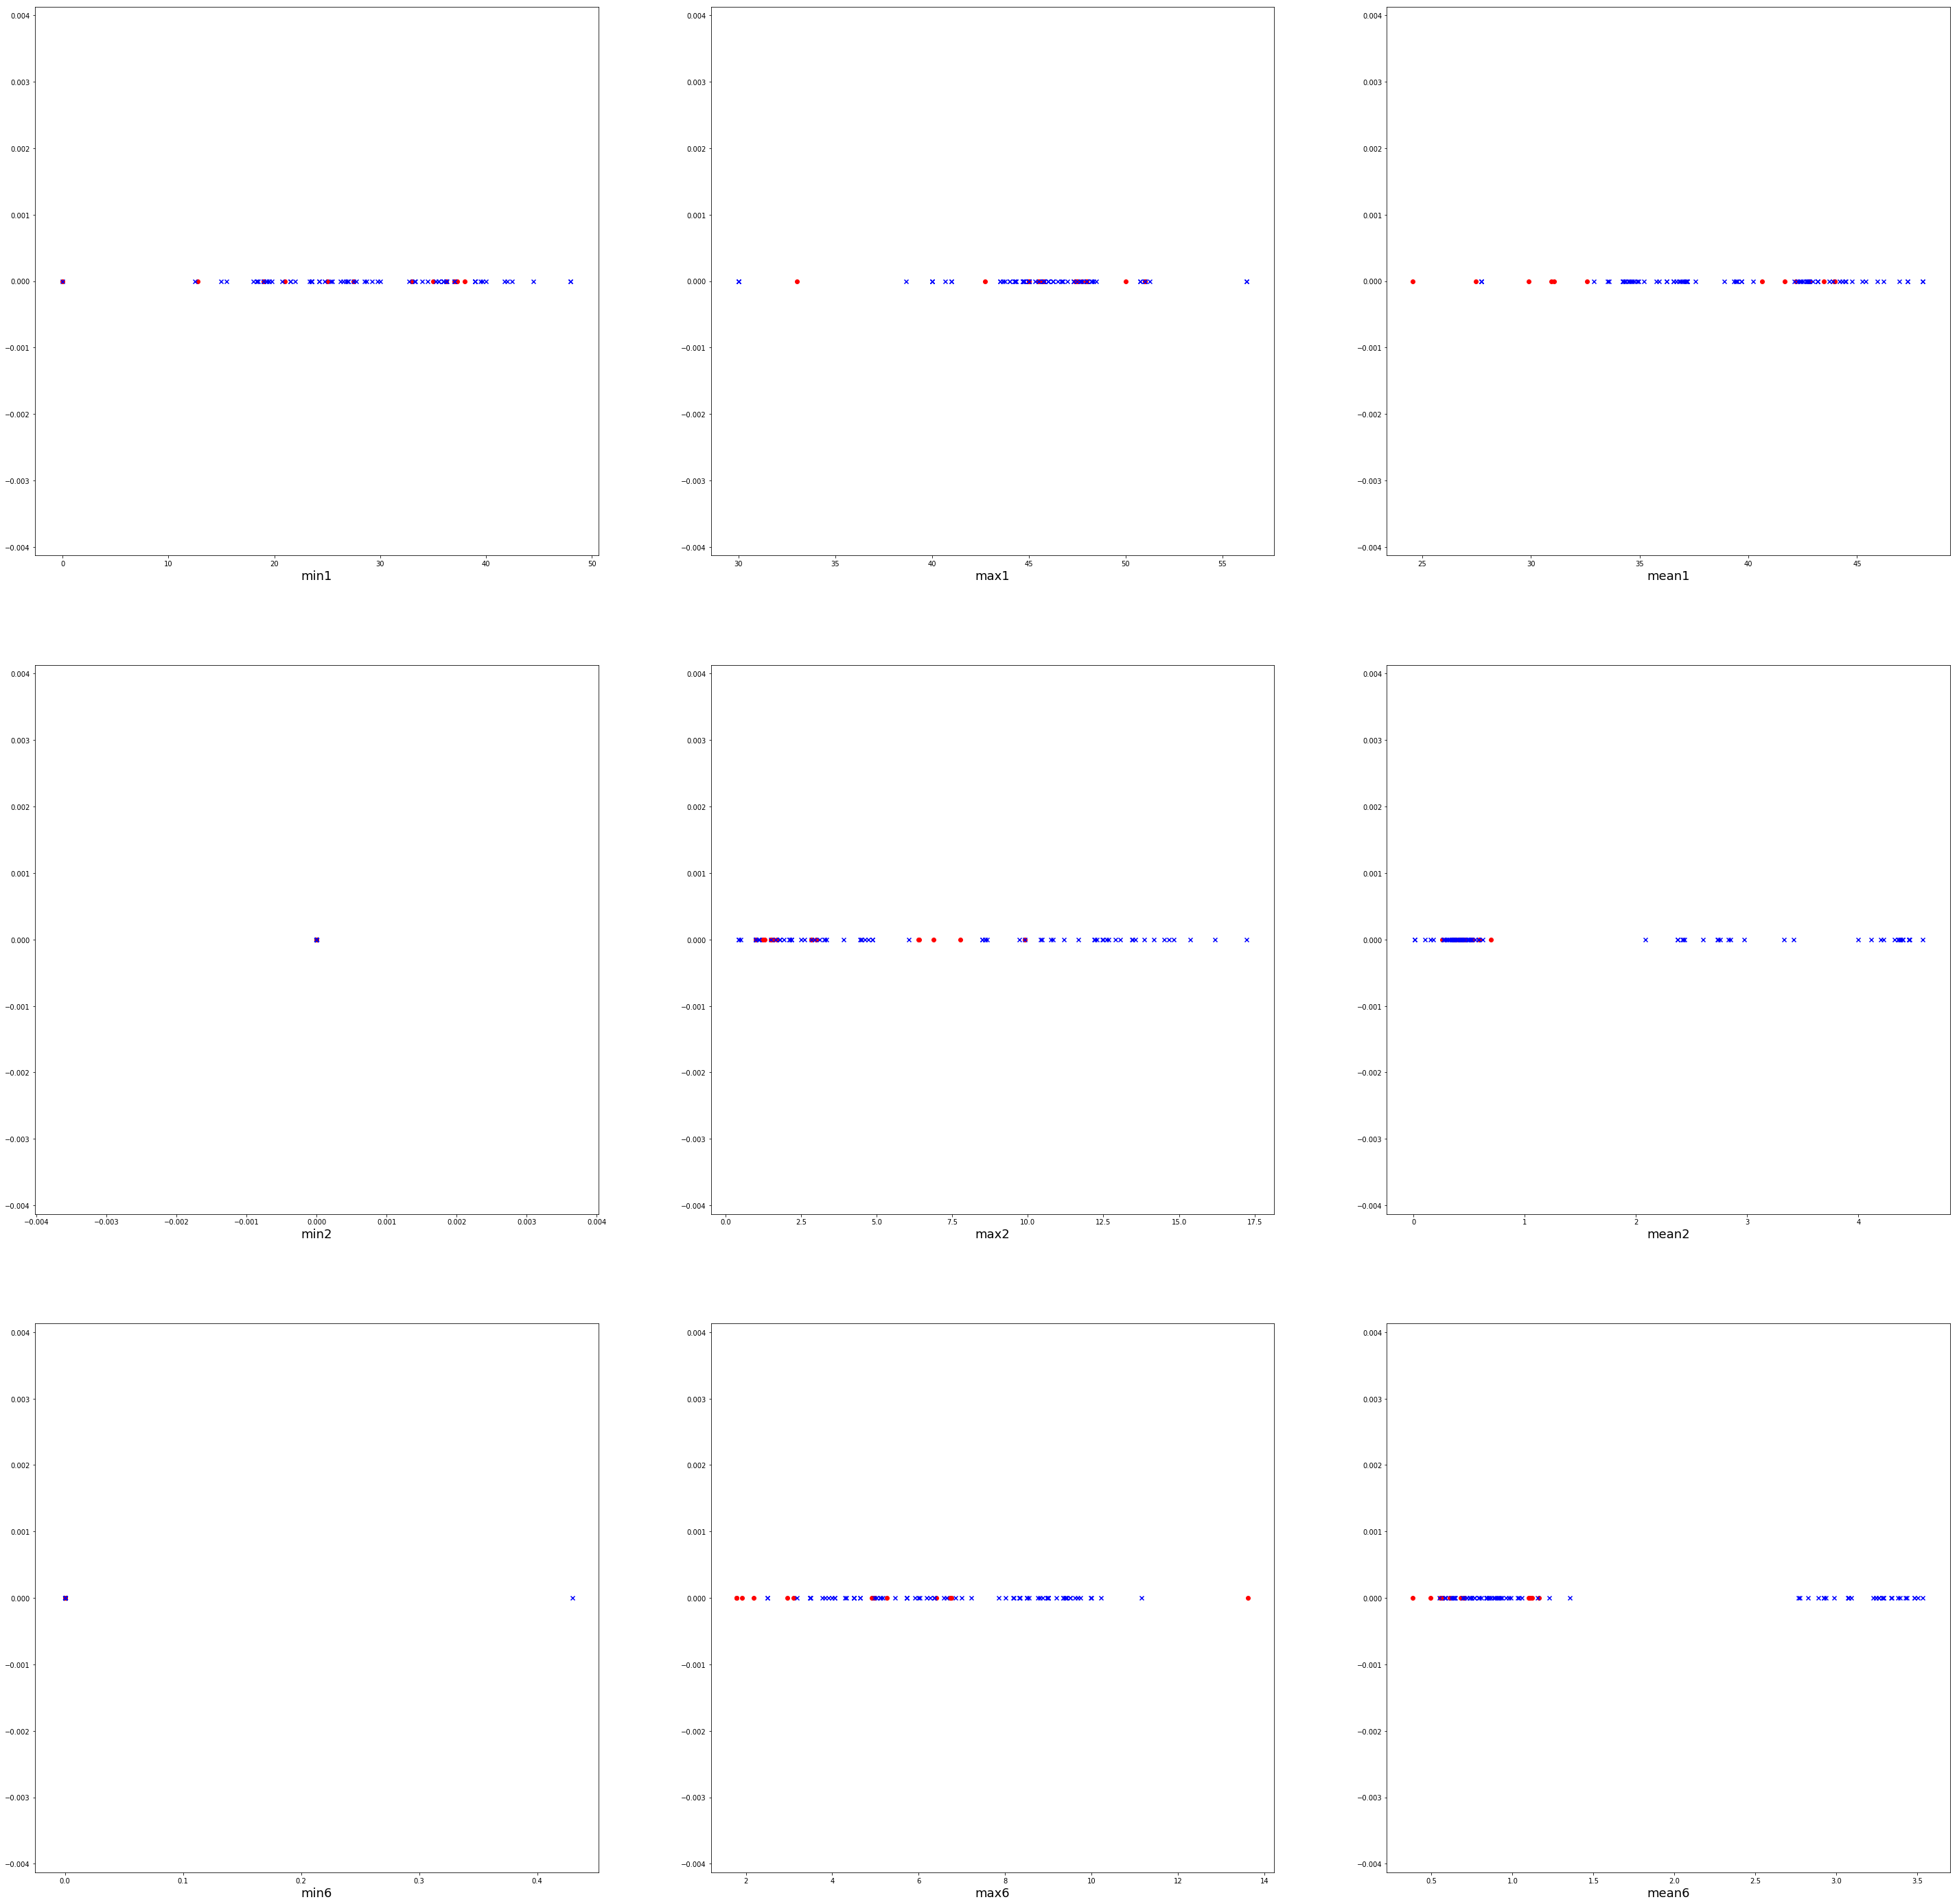

In [5]:
'''
d(i)
Choose the optional time domain features ["min", "max", "mean"]
'''
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
selected_feature_names = []
for i in range (len(feature_column_names)):
    temp_name = feature_column_names[i]
    if temp_name.startswith("min") or temp_name.startswith("max") or temp_name.startswith("mean"):
        if "1" in temp_name or "2" in temp_name or "6" in temp_name:
            selected_feature_names.append(feature_column_names[i])
        
selected_feature_data = feature_data[selected_feature_names]

bending_instances = BENDING_ONE_FILE_COUNT + BENDING_TWO_FILE_COUNT
'''
# pair wise features scatter plot
fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(50,50))
index = 0 
fontSize = 18

for i in range(len(selected_feature_names) - 1):
    for j in range(i+1, len(selected_feature_names)):
        for k in range(88):
            x = selected_feature_data[selected_feature_names[i]][k]
            y = selected_feature_data[selected_feature_names[j]][k]
            if(k < bending_instances): 
                axes[int(index/2), index%2].scatter(x, y, marker="o", color="red")
            else : 
                axes[int(index/2), index%2].scatter(x, y, marker="x", color="blue")
        axes[int(index/2), index%2].set_xlabel(selected_feature_names[i], fontsize=fontSize)
        axes[int(index/2), index%2].set_ylabel(selected_feature_names[j], fontsize=fontSize)
        
        index += 1
'''
# single feature scatter plot 
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(50,50))
index = 0 
fontSize = 18
for i in range(len(selected_feature_names)):
    y = 0
    for k in range(88):
        x = selected_feature_data[selected_feature_names[i]][k]
        if(k < bending_instances): 
            axes[int(index/3), index%3].scatter(x, y, marker="o", color="red")
        else : 
            axes[int(index/3), index%3].scatter(x, y, marker="x", color="blue")
    axes[int(index/3), index%3].set_xlabel(selected_feature_names[i], fontsize=fontSize)

    index += 1
plt.show()

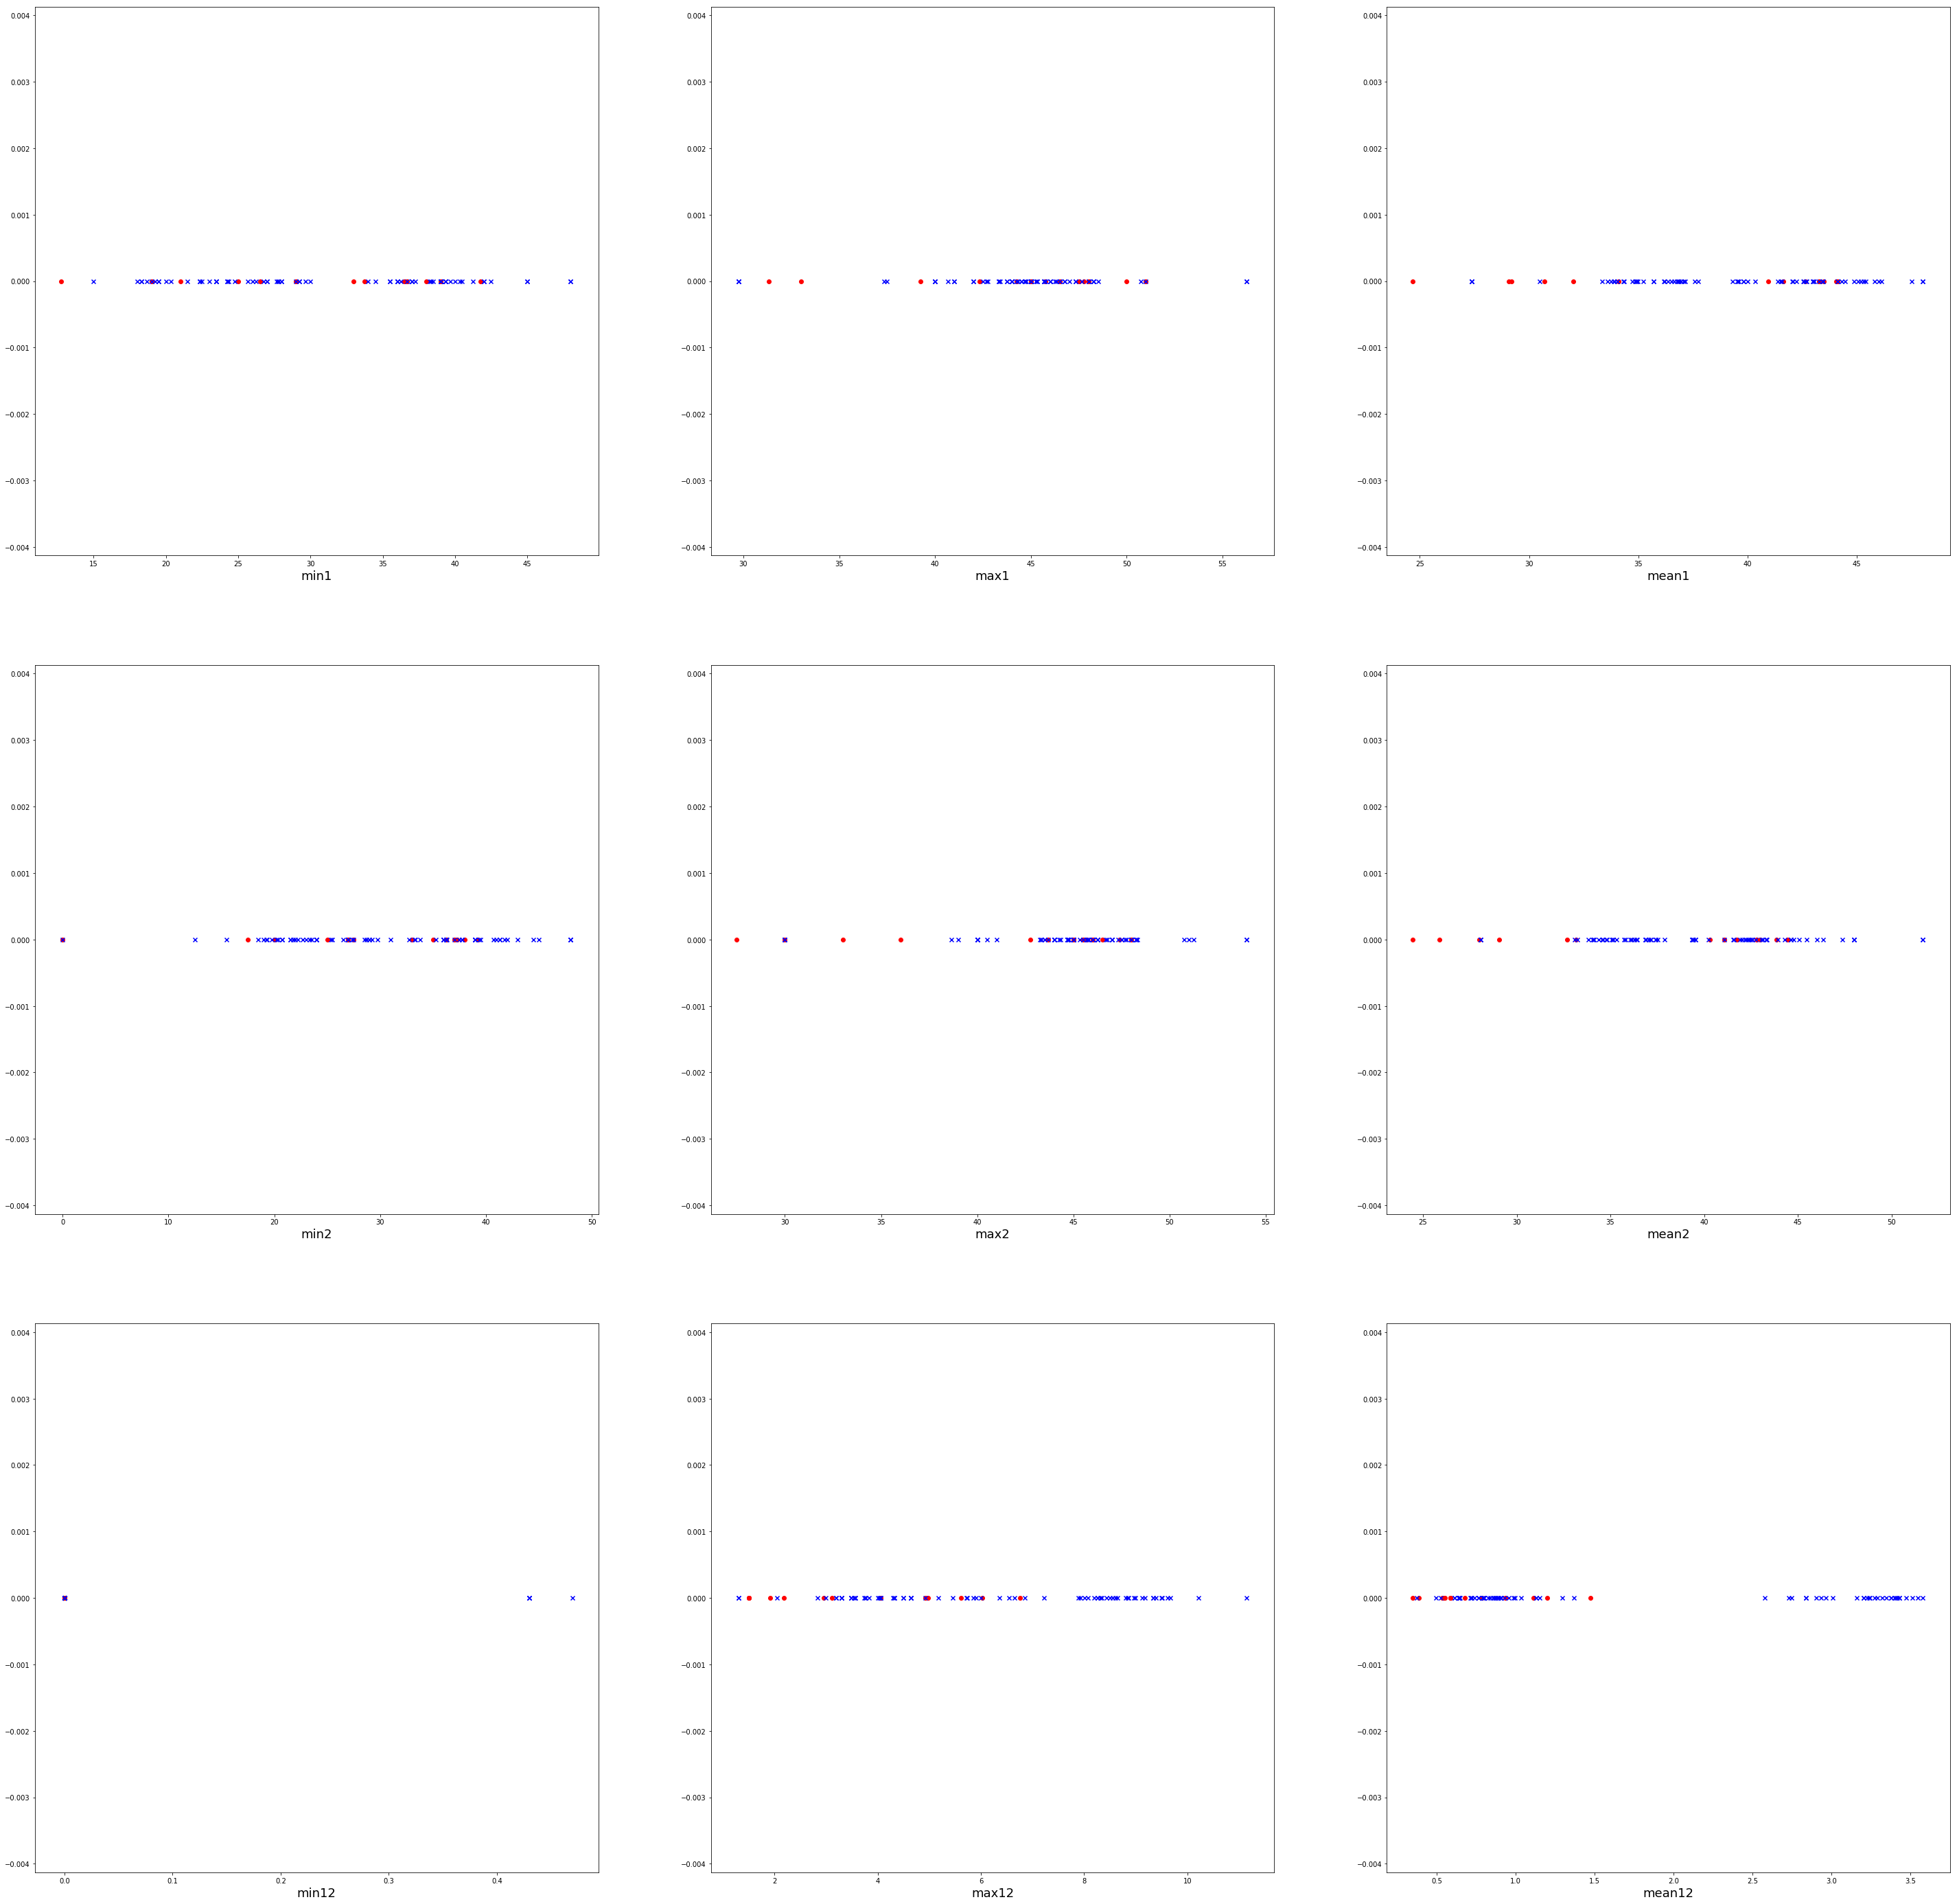

There is not many considerable difference in result with d(i). These suggests the varaible is likely         normaly distributed and that it does not correlate with time when split in two.


In [6]:
'''
d(ii)
'''
feature_names = ["min", "max", "mean"]
feature_column_names = [] 
for i in range (6*2) : 
    for name in feature_names: 
        feature_column_names.append(name + str(i+1))

#break time series in d(ii) in to upper and lower part, and assign the order as (up, down , up , down...)
def generateFeatureDataD2(activity_data):
    entries = []
    for i in range (len(activity_data)):
        temp_df = activity_data[i]
        mins_up = temp_df.iloc[:240,:].min()
        maxes_up = temp_df.iloc[:240,:].max()
        means_up = temp_df.iloc[:240,:].mean()
        
        mins_down = temp_df.iloc[240:,:].min()
        maxes_down = temp_df.iloc[240:,:].max()
        means_down = temp_df.iloc[240:,:].mean()
        
        temp_entry = []
        # 2*3*6=36
        for j in range(6) : 
            temp_entry.append(mins_up[j+1]) 
            temp_entry.append(maxes_up[j+1]) 
            temp_entry.append(means_up[j+1])
            
            temp_entry.append(mins_down[j+1]) 
            temp_entry.append(maxes_down[j+1]) 
            temp_entry.append(means_down[j+1])
            
        entries.append(temp_entry)
        
    return pd.DataFrame(entries, columns=feature_column_names)

frames = []
for i in range (len(activity_data_all)):
    frames.append(generateFeatureDataD2(activity_data_all[i]))

# min max mean up and down feature data 
feature_data_up_down = pd.concat(frames)
feature_data_up_down.index = range(88)

#chose min1,2,12, max1,2,12 and mean1,2,12
selected_feature_names_D2 = []
for i in range (len(feature_column_names)):
    temp_name = feature_column_names[i]
    if "1" in temp_name or "2" in temp_name or "12" in temp_name:
        if "0" not in temp_name and "11" not in temp_name:
            selected_feature_names_D2.append(feature_column_names[i])


'''
# pair wise features scatter plot 
selected_feature_data_D2 = feature_data_up_down[selected_feature_names_D2]

fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(50,200))
index = 0 
for i in range(len(selected_feature_names) - 1):
    for j in range(i+1, len(selected_feature_names)):
        for k in range(88):
            x = selected_feature_data_D2[selected_feature_names_D2[i]][k]
            y = selected_feature_data_D2[selected_feature_names_D2[j]][k]
            if(k < bending_instances): 
                axes[int(index/2), index%2].scatter(x, y, marker="o", color="red")
            else : 
                axes[int(index/2), index%2].scatter(x, y, marker="x", color="blue")
        axes[int(index/2), index%2].set_xlabel(selected_feature_names_D2[i], fontsize=fontSize)
        axes[int(index/2), index%2].set_ylabel(selected_feature_names_D2[j], fontsize=fontSize)
        
        index += 1
plt.show()
'''
#single feature scatter plot 
selected_feature_data_D2 = feature_data_up_down[selected_feature_names_D2]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(50,50))
index = 0 
for i in range(len(selected_feature_names)):
    y = 0
    for k in range(88):
        x = selected_feature_data_D2[selected_feature_names_D2[i]][k]
        if(k < bending_instances): 
            axes[int(index/3), index%3].scatter(x, y, marker="o", color="red")
        else : 
            axes[int(index/3), index%3].scatter(x, y, marker="x", color="blue")
    axes[int(index/3), index%3].set_xlabel(selected_feature_names_D2[i], fontsize=fontSize)

    index += 1
plt.show()


print("There is not many considerable difference in result with d(i). These suggests the varaible is likely \
        normaly distributed and that it does not correlate with time when split in two.")

In [7]:
'''
d(iii)
'''
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings("ignore", category=FutureWarning)

TESTING_INDEXES = [0,1, 7,8, 13,14,15, 28,29,30, 43,44,45, 58,59,60, 73,74,75]
TESTING_LENGTH = len(TESTING_INDEXES)
TESTING_TARGET_SEPARATOR = 4 
TRAINING_INDEXES = []
for i in range(88): 
    if i not in TESTING_INDEXES: 
        TRAINING_INDEXES.append(i)
TRAINING_LENGTH = len(TRAINING_INDEXES)
TRAINING_TARGET_SEPARATOR = 9


TESTING_TARGETS = [] 
for i in range(TESTING_LENGTH): 
    if i < TESTING_TARGET_SEPARATOR: 
        TESTING_TARGETS.append(1)
    else : 
        TESTING_TARGETS.append(0)
np_test_targets = np.array(TESTING_TARGETS)


TRAINING_TARGETS = [] 
for i in range(TRAINING_LENGTH): 
    if i < TRAINING_TARGET_SEPARATOR: 
        TRAINING_TARGETS.append(1)
    else : 
        TRAINING_TARGETS.append(0)
np_train_targets = np.array(TRAINING_TARGETS)


'''
BEGIN func: generateFeatureDataD3
activity_data=list of instances for a given activity

'''
def generateFeatureDataD3(activity_data, number_of_slice):
    entries = []
    for i in range (len(activity_data)):
        temp_df = activity_data[i]
        row_count = temp_df.shape[0]
        sub_series_row_count = math.ceil(row_count/number_of_slice) 
        head = 0 
        tail = sub_series_row_count
        temp_entry = []
        while head < row_count: 
            temp_mins = temp_df.iloc[head:tail,:].min()
            temp_maxes = temp_df.iloc[head:tail,:].max()
            temp_means = temp_df.iloc[head:tail,:].mean()
            
            temp_medians = temp_df.iloc[head:tail,:].median()
            temp_stds = temp_df.iloc[head:tail,:].std()
            temp_first_quarts = temp_df.iloc[head:tail,:].quantile(0.25)
            temp_third_quarts = temp_df.iloc[head:tail,:].quantile(0.75)
            # 3*6 features per sub_instance
            for j in range(6) : 
                temp_entry.append(temp_mins[j+1]) 
                temp_entry.append(temp_maxes[j+1]) 
                temp_entry.append(temp_means[j+1])
                
                temp_entry.append(temp_medians[j+1]) 
                temp_entry.append(temp_stds[j+1]) 
                temp_entry.append(temp_first_quarts[j+1])
                temp_entry.append(temp_third_quarts[j+1])
                
            # 3*6 * number_of_slice total features
            head = tail 
            tail += sub_series_row_count
            if tail > row_count:
                tail = row_count
        #assert (len(temp_entry) == 3*6*number_of_slice),"Columns are wrong!"  
        entries.append(temp_entry)
    return pd.DataFrame(entries)

'''
END func: generateFeatureDataD3
'''

# column name unnecessary
# feature_names = ["min", "max", "mean"]
# feature_column_names_20 = [] 
# for i in range (6*20) : 
#     for name in feature_names: 
#         feature_column_names_20.append(name + str(i+1))

#error_rate = 1 
max_score = 0
pair = (0,0)
model = LogisticRegression(C=1e42)  
best_rfecv = None 
for l in range(1, 21, 1):
    # extract time domain features for each slice
    temp_frames = []
    for i in range (len(activity_data_all)): 
        temp_frames.append(generateFeatureDataD3(activity_data_all[i], l))
    temp_feature_data = pd.concat(temp_frames)
    temp_feature_data.index = range(88)
 
    temp_training_data = temp_feature_data.iloc[TRAINING_INDEXES, :]
    temp_training_data.index = range(TRAINING_LENGTH)
    temp_testing_data = temp_feature_data.iloc[TESTING_INDEXES, :]
    temp_testing_data.index = range(TESTING_LENGTH)

    number_of_features = temp_feature_data.shape[1]
    print ("At l =",  l, "slices, there are:" ,number_of_features, "number_of_features: ")
    
#     #method 1, self-wrote function, RUNTIME EXPLODED
#     for p in range (number_of_features,0, -1):
#         model = LogisticRegression(C=1e42)
#         rfe = RFE(model, p)
#         # use stratified k fold to obtain 5 splits 
#         skf = StratifiedKFold(n_splits=5)
#         temp_total_error = 0
        
#         # Cross Validation the right way: https://www.nodalpoint.com/not-perform-feature-selection/
#         for train_index, test_index in skf.split(temp_training_data.values, np_train_targets):
#             rfe = rfe.fit(temp_training_data.iloc[train_index,:].values, np_train_targets[np.array(train_index)])
#             score = rfe.score(temp_training_data.iloc[test_index,:].values, np_train_targets[np.array(test_index)])
#             #  print (rfe.support_)
#             #  print(rfe.ranking_)
#             temp_error = 1 - score 
#             temp_total_error += temp_error
            
#         avg_total_error = temp_total_error/5
#         if avg_total_error < error_rate: 
#             error_rate = avg_total_error
#             pair = (l,p)
#         elif avg_total_error == error_rate:
#             if p < pair[1]: 
#                 pair = (l, p)

    #Method 2: Simpler approach CV with REF : https://scikit-learn.org/stable/auto_examples/feature_selection/
    #plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py       
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5),scoring='accuracy')
    rfecv.fit(temp_training_data.values, np_train_targets)
    print("\tOptimal number of features p is:", rfecv.n_features_, ", Optimal score is:", max(rfecv.grid_scores_))
    
    if max(rfecv.grid_scores_) > max_score:
        max_score = max(rfecv.grid_scores_)
        pair = (l , rfecv.n_features_)
        best_rfecv = rfecv
#     # plt the scoring for different features 
#     plt.figure()
#     plt.xlabel("Number of features selected")
#     plt.ylabel("Cross validation score (nb of correct classifications)")
#     plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
#     plt.show()

print ("(l,p) pair:", pair, "max score : ", max_score) 

At l = 1 slices, there are: 42 number_of_features: 
	Optimal number of features p is: 6 , Optimal score is: 0.9714285714285715
At l = 2 slices, there are: 84 number_of_features: 
	Optimal number of features p is: 6 , Optimal score is: 0.9714285714285715
At l = 3 slices, there are: 126 number_of_features: 
	Optimal number of features p is: 4 , Optimal score is: 0.9857142857142858
At l = 4 slices, there are: 168 number_of_features: 
	Optimal number of features p is: 4 , Optimal score is: 0.9714285714285715
At l = 5 slices, there are: 210 number_of_features: 
	Optimal number of features p is: 1 , Optimal score is: 0.9571428571428573
At l = 6 slices, there are: 252 number_of_features: 
	Optimal number of features p is: 14 , Optimal score is: 0.9714285714285715
At l = 7 slices, there are: 294 number_of_features: 
	Optimal number of features p is: 8 , Optimal score is: 0.9714285714285715
At l = 8 slices, there are: 336 number_of_features: 
	Optimal number of features p is: 5 , Optimal score 

### d(iii) Right and Wrong way of CV 
The right way of cross validation on feature selection is to fit the model last. After selecting the number of features and after selecting the training set of data. The wrong way is to fit the model right after selecing features and test selected cross-validation training set on that model.

confusion matrix:
 [[60  0]
 [ 0  9]]


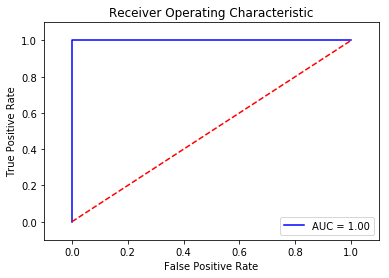

coefficients: [[ 1.51054144  2.35270701 -1.54517095 -1.21398161]]
p-values for each coefficients are: [0.41093728213964253, 0.09560072788215015, 0.06599726039000317, 0.46047259599389734]


In [8]:
'''
d(iii) continue ; d(iv)
PLOT ROC AUC : https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
'''

from sklearn.metrics import confusion_matrix
from sklearn import metrics
import statsmodels.api as sm 
BEST_SPLIT = pair[0]
BEST_FEATURE_NUMBER = pair[1]
frames = []
for i in range (len(activity_data_all)): 
    frames.append(generateFeatureDataD3(activity_data_all[i], BEST_SPLIT))

feature_data = pd.concat(frames)
feature_data.index = range(88)
training_data = feature_data.iloc[TRAINING_INDEXES, :]
training_data.index = range(TRAINING_LENGTH)
testing_data = feature_data.iloc[TESTING_INDEXES, :]
testing_data.index = range(TESTING_LENGTH)

model = LogisticRegression(C=1e42)
rfe = RFE(model, BEST_FEATURE_NUMBER)
rfe.fit(training_data.values, np_train_targets)
score = rfe.score(testing_data.values, np_test_targets)
#show p-vlaues with sm 
selected_feature_indexes = []
for i in range (len(rfe.support_)): 
    if rfe.support_[i]: 
        selected_feature_indexes.append(i)
sm_train_data = training_data.iloc[:, selected_feature_indexes] 

train_true = np_train_targets
train_pred = rfe.predict(training_data.values)
print('confusion matrix:\n', confusion_matrix(train_true, train_pred))
#print(rfe.predict_proba(temp_testing_data.values * 100))
probs = rfe.predict_proba(training_data.values)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(np_train_targets, preds)
roc_auc = metrics.auc(fpr, tpr)
# print(roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#coeffients
print ('coefficients:',rfe.estimator_.coef_)

#p-values code from piazza
from sklearn import linear_model
import scipy.stats as stat

class LogisticReg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values

        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij
        return self

logisticReg = LogisticReg()
logisticReg.fit(sm_train_data, np_train_targets)
print("p-values for each coefficients are:", logisticReg.p_values)



# Explain high p values Hauck-Donner effect: 
# https://stats.stackexchange.com/questions/102695/high-p-values-for-logistic-regression-variable-that-perfectly-separates

In [9]:
'''
d(v)
'''
test_score = rfe.score(testing_data.values, np_test_targets)
print ("Test accuracy:", test_score)
print ("Test accuracy is better than cross validation accuracy beacuse we have more data to train the model whereas\
        is cross validation we only used 4/5 of the training data.")
#equal to CV accuracy

Test accuracy: 1.0
Test accuracy is better than cross validation accuracy beacuse we have more data to train the model whereas        is cross validation we only used 4/5 of the training data.


d(vi): Yes, according to the ROC curve, the classes are well seperated.
d(vii): Yes, as there are a lot more non bending instances comparing to bending instance 60/9, the classes are imbalance.
Test score for 9 number of negative classes is 0.8947368421052632
Training set confusion matrix:
 [[9 0]
 [0 9]]


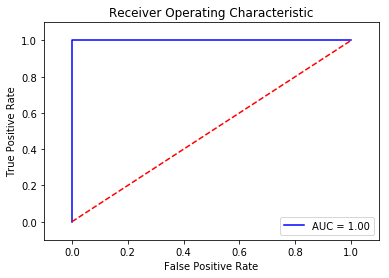

In [10]:
'''
d(vi), (vii)
'''
print("d(vi): Yes, according to the ROC curve, the classes are well seperated.")
print("d(vii): Yes, as there are a lot more non bending instances comparing to bending instance 60/9, the \
classes are imbalance.") 
import random

number_of_positive = 9
number_of_negative = 60

positive_samples_indexes = []
for i in range (9):
    positive_samples_indexes.append(i)

# you can change 10 to 60 to see result of all down sampling sizes 
for i in range (9, 10, 1): 
    negative_samples_indexes = random.sample(range(9, 69, 1), i)
    selected_indexes = positive_samples_indexes + negative_samples_indexes 
    model = LogisticRegression(C=1e42)
    model.fit(training_data.iloc[selected_indexes, :].values, np_train_targets[selected_indexes])
    temp_score = model.score(testing_data.values, np_test_targets)
    print("Test score for",i,"number of negative classes is",temp_score)
    
    temp_train_true = np_train_targets[selected_indexes]
    temp_train_pred = model.predict(training_data.iloc[selected_indexes, :].values)
    print('Training set confusion matrix:\n', confusion_matrix(temp_train_true, temp_train_pred))
    temp_probs = model.predict_proba(training_data.iloc[selected_indexes, :].values)
    temp_preds = temp_probs[:,1]

    fpr, tpr, threshold = metrics.roc_curve(np_train_targets[selected_indexes], temp_preds)
    roc_auc = metrics.auc(fpr, tpr)
    # print(roc_auc)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [11]:
'''
e(i)
'''
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
max_score = 0
split_C_pair = (0,0)
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
for l in range(1, 21, 1): 
    temp_frames = []
    for i in range (len(activity_data_all)): 
        temp_frames.append(generateFeatureDataD3(activity_data_all[i], l))
    temp_feature_data = pd.concat(temp_frames)
    temp_feature_data.index = range(88)
    temp_training_data = temp_feature_data.iloc[TRAINING_INDEXES, :]
    temp_training_data.index = range(TRAINING_LENGTH)
    #normalize data 
    np_train_features_scaled = min_max_scaler.fit_transform(temp_training_data.values)

    number_of_features = temp_feature_data.shape[1]
    
    print ("l:",  l, ", number_of_features: ", number_of_features)
    temp_model = LogisticRegressionCV(penalty="l1", solver="liblinear", cv=StratifiedKFold(5),Cs=Cs)  
    temp_model.fit(np_train_features_scaled, np_train_targets)
    temp_max_score = 0 
    temp_best_j = -1
    for key in temp_model.scores_: 
         for cv_fold_scores in temp_model.scores_[key]: 
            for j in range(len(cv_fold_scores)):
                if cv_fold_scores[j] > max_score: 
                    split_C_pair = (l, Cs[j])
                    max_score =  cv_fold_scores[j]
                if cv_fold_scores[j] > temp_max_score: 
                    temp_max_score =  cv_fold_scores[j]
                    temp_best_j = j
                
    print("Optimal score is :", temp_max_score, ", Optimal Cs is :", Cs[temp_best_j])
    
print("(l,c) pair:", split_C_pair, "max score : ", max_score)


l: 1 , number_of_features:  42
Optimal score is : 1.0 , Optimal Cs is : 10
l: 2 , number_of_features:  84
Optimal score is : 1.0 , Optimal Cs is : 10
l: 3 , number_of_features:  126
Optimal score is : 1.0 , Optimal Cs is : 10
l: 4 , number_of_features:  168
Optimal score is : 1.0 , Optimal Cs is : 10
l: 5 , number_of_features:  210
Optimal score is : 1.0 , Optimal Cs is : 10
l: 6 , number_of_features:  252
Optimal score is : 1.0 , Optimal Cs is : 10
l: 7 , number_of_features:  294
Optimal score is : 1.0 , Optimal Cs is : 10
l: 8 , number_of_features:  336
Optimal score is : 1.0 , Optimal Cs is : 10
l: 9 , number_of_features:  378
Optimal score is : 1.0 , Optimal Cs is : 10
l: 10 , number_of_features:  420
Optimal score is : 1.0 , Optimal Cs is : 10
l: 11 , number_of_features:  462
Optimal score is : 1.0 , Optimal Cs is : 10
l: 12 , number_of_features:  504
Optimal score is : 1.0 , Optimal Cs is : 10
l: 13 , number_of_features:  546
Optimal score is : 1.0 , Optimal Cs is : 10
l: 14 , nu

In [12]:
'''
e(ii)
'''
BEST_SPLIT = split_C_pair[0]
BEST_C = split_C_pair[1]
frames = []
for i in range (len(activity_data_all)): 
    frames.append(generateFeatureDataD3(activity_data_all[i], BEST_SPLIT))

feature_data = pd.concat(frames)
feature_data.index = range(88)
training_data = feature_data.iloc[TRAINING_INDEXES, :]
training_data.index = range(TRAINING_LENGTH)
testing_data = feature_data.iloc[TESTING_INDEXES, :]
testing_data.index = range(TESTING_LENGTH)

np_train_features_scaled = min_max_scaler.fit_transform(training_data.values)
np_test_features_scaled = min_max_scaler.fit_transform(testing_data.values)

model = LogisticRegression(penalty="l1", solver="liblinear", C=BEST_C)
model.fit(np_train_features_scaled, np_train_targets)
score = model.score(np_test_features_scaled, np_test_targets)
print("L1 penalized score is:", score)
print("L1 performs equaly good as p-values selection method. L1 is easier to implement.")

L1 penalized score is: 1.0
L1 performs equaly good as p-values selection method. L1 is easier to implement.


In [13]:
'''
f(i)
'''
warnings.filterwarnings("ignore", category=Warning)
multiclass_targets = []
for i in range (len(FOLDERS)): 
    if FOLDERS[i] == "bending1": 
        for j in range (BENDING_ONE_FILE_COUNT):
            multiclass_targets.append(i)
    elif FOLDERS[i] == "bending2": 
        for j in range (BENDING_TWO_FILE_COUNT):
            multiclass_targets.append(i)
    else:
        for j in range(GENERAL_FILE_COUNT): 
            multiclass_targets.append(i)
            
multiclass_test_targets  = []         
multiclass_train_targets  = []   
for i in range(88):
    if i in TESTING_INDEXES: 
        multiclass_test_targets.append(multiclass_targets[i])
    else :
        multiclass_train_targets.append(multiclass_targets[i])
        
np_test_targets = np.array(multiclass_test_targets)
np_train_targets = np.array(multiclass_train_targets)

max_score = 0
split_C_pair = (0,0)
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
for l in range(1, 21, 1): 
    temp_frames = []
    for i in range (len(activity_data_all)): 
        temp_frames.append(generateFeatureDataD3(activity_data_all[i], l))
    temp_feature_data = pd.concat(temp_frames)
    temp_feature_data.index = range(88)
    temp_training_data = temp_feature_data.iloc[TRAINING_INDEXES, :]
    temp_training_data.index = range(TRAINING_LENGTH)
    #normalize data 
    np_train_features_scaled = min_max_scaler.fit_transform(temp_training_data.values)

    number_of_features = temp_feature_data.shape[1]
            
    print ("l:",  l, ", number_of_features: ", number_of_features)
    temp_model = LogisticRegressionCV(solver="saga", multi_class="multinomial",
                                      penalty="l1", cv=StratifiedKFold(5), Cs=Cs, max_iter=100)  
    temp_model.fit(np_train_features_scaled, np_train_targets)
    temp_max_score = 0 
    temp_best_j = -1
    for key in temp_model.scores_: 
         for cv_fold_scores in temp_model.scores_[key]: 
            for j in range(len(cv_fold_scores)):
                if cv_fold_scores[j] > max_score: 
                    split_C_pair = (l, Cs[j])
                    max_score =  cv_fold_scores[j]
                if cv_fold_scores[j] > temp_max_score: 
                    temp_max_score =  cv_fold_scores[j]
                    temp_best_j = j
                
    print("Optimal score is :", temp_max_score, ", Optimal Cs is :", Cs[temp_best_j])
    
print("(l,c) pair:", split_C_pair, "max score : ", max_score)

l: 1 , number_of_features:  42
Optimal score is : 0.9411764705882353 , Optimal Cs is : 10
l: 2 , number_of_features:  84
Optimal score is : 1.0 , Optimal Cs is : 10
l: 3 , number_of_features:  126
Optimal score is : 0.9166666666666666 , Optimal Cs is : 100
l: 4 , number_of_features:  168
Optimal score is : 1.0 , Optimal Cs is : 100
l: 5 , number_of_features:  210
Optimal score is : 0.9166666666666666 , Optimal Cs is : 1
l: 6 , number_of_features:  252
Optimal score is : 0.9411764705882353 , Optimal Cs is : 1
l: 7 , number_of_features:  294
Optimal score is : 0.9166666666666666 , Optimal Cs is : 1
l: 8 , number_of_features:  336
Optimal score is : 0.9166666666666666 , Optimal Cs is : 1
l: 9 , number_of_features:  378
Optimal score is : 0.9166666666666666 , Optimal Cs is : 1
l: 10 , number_of_features:  420
Optimal score is : 0.9166666666666666 , Optimal Cs is : 1
l: 11 , number_of_features:  462
Optimal score is : 0.9166666666666666 , Optimal Cs is : 1
l: 12 , number_of_features:  504
O

Test error is: 0.1578947368421053


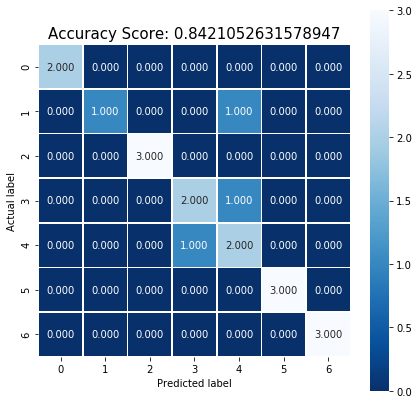

In [14]:
'''
f(i) continue 
'''
import seaborn as sns
# error rate 
BEST_SPLIT = split_C_pair[0]
BEST_C = split_C_pair[1]

frames = []

for i in range (len(activity_data_all)): 
    frames.append(generateFeatureDataD3(activity_data_all[i], BEST_SPLIT))
    
feature_data = pd.concat(frames)
feature_data.index = range(88)
training_data = feature_data.iloc[TRAINING_INDEXES, :]
training_data.index = range(TRAINING_LENGTH)
testing_data = feature_data.iloc[TESTING_INDEXES, :]
testing_data.index = range(TESTING_LENGTH)

np_train_features_scaled = min_max_scaler.fit_transform(training_data.values)
np_test_features_scaled = min_max_scaler.fit_transform(testing_data.values)

model = LogisticRegression(solver="saga", multi_class="multinomial",
                           penalty="l1", C=BEST_C)
model.fit(np_train_features_scaled, np_train_targets)
score = model.score(np_test_features_scaled, np_test_targets)
print("Test error is:", 1 - score)

# confusion_matrix
# confusion matrix of multinomial classification: 
# https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

confusion_matrix = metrics.confusion_matrix(np_test_targets, model.predict(np_test_features_scaled))
plt.figure(figsize=(7,7))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);




In [15]:
'''
f(ii), f(iii)
'''
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
max_score = 0
split_model_pair = (0,"")
for l in range(1, 21, 1): 
    temp_frames = []
    for i in range (len(activity_data_all)): 
        temp_frames.append(generateFeatureDataD3(activity_data_all[i], l))
    temp_feature_data = pd.concat(temp_frames)
    temp_feature_data.index = range(88)
    temp_training_data = temp_feature_data.iloc[TRAINING_INDEXES, :]
    temp_training_data.index = range(TRAINING_LENGTH)
    #normalize data 
    np_train_features_scaled = min_max_scaler.fit_transform(temp_training_data.values)

    number_of_features = temp_feature_data.shape[1]
            
    print ("l:",  l, ", number_of_features: ", number_of_features)
    temp_gaussian_model = GaussianNB()
    temp_multinomial_model = MultinomialNB()
    
    # Cross Validation the right way: https://www.nodalpoint.com/not-perform-feature-selection/
    skf = StratifiedKFold(n_splits=5)

    gaussian_score = 0
    multinomial_score = 0
    for train_index, test_index in skf.split(np_train_features_scaled, np_train_targets):
        temp_gaussian_model.fit(np_train_features_scaled[train_index, :], np_train_targets[np.array(train_index)])
        temp_gaussian_score = temp_gaussian_model.score(np_train_features_scaled[train_index, :], np_train_targets[np.array(train_index)])
        gaussian_score += temp_gaussian_score
        
        temp_multinomial_model.fit(np_train_features_scaled[train_index, :], np_train_targets[np.array(train_index)])
        temp_multinomial_score = temp_multinomial_model.score(np_train_features_scaled[train_index, :], np_train_targets[np.array(train_index)])
        multinomial_score += temp_multinomial_score
    avg_gaussian_score = gaussian_score/5
    avg_multinomial_score = multinomial_score/5
    print ("Avg gaussian score is:", avg_gaussian_score, "Avg multinomial score is:",avg_multinomial_score)
    
    if avg_gaussian_score > avg_multinomial_score: 
        if avg_gaussian_score > max_score: 
            split_model_pair = (l, "gaussian")
            max_score = avg_gaussian_score
    else: 
        if avg_multinomial_score > max_score: 
            split_model_pair = (l, "multinomial")
            max_score = avg_multinomial_score
    
print("(l, model) pair:", split_model_pair, "max score : ", max_score)
print ("Gaussian is better")

l: 1 , number_of_features:  42
Avg gaussian score is: 0.9964912280701753 Avg multinomial score is: 0.8047210200567733
l: 2 , number_of_features:  84
Avg gaussian score is: 0.9929824561403509 Avg multinomial score is: 0.8543371027037088
l: 3 , number_of_features:  126
Avg gaussian score is: 0.9965517241379309 Avg multinomial score is: 0.8379868770068407
l: 4 , number_of_features:  168
Avg gaussian score is: 0.9964912280701753 Avg multinomial score is: 0.8593163944343617
l: 5 , number_of_features:  210
Avg gaussian score is: 0.9930429522081065 Avg multinomial score is: 0.8732304900181488
l: 6 , number_of_features:  252
Avg gaussian score is: 0.9965517241379309 Avg multinomial score is: 0.8735678719344782
l: 7 , number_of_features:  294
Avg gaussian score is: 1.0 Avg multinomial score is: 0.8774745218483876
l: 8 , number_of_features:  336
Avg gaussian score is: 0.9783935967239052 Avg multinomial score is: 0.888277723486435
l: 9 , number_of_features:  378
Avg gaussian score is: 1.0 Avg mul